In [1]:
import sys
# sys.path.append(r'E:/0code')
# sys.path.append(r'/home/wyf/0code')
# sys.path.append(r'/home/wangyf226/0code')
sys.path.append(r'/BIGDATA1/nsccgz_yfdu_1/asc19/wyf/0code')

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
from pyml.ensemble.regression import GradientBoostingRegression
from pyml.tree.regression import DecisionTreeRegressor
from pyml.feature_extraction.text import CountVectorizer
from pyml.linear_model.regression import LinearRegression
from pyml.neighbors.classification import KNeighborsClassifier
from pyml.metrics.regression import pearson_correlation
from pyml.model_selection import KFold
from pyml.model_selection import ShuffleSplit
from pyml.preprocessing import StandardScaler
from pyml.logger import logger
from sklearn.preprocessing import MinMaxScaler
import logging
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def save_model(model, name):
    with open(name,'wb') as f:
        pickle.dump(model, f)
def load_model(name):
    with open(name,'rb') as f:
        pickle.load(f,model)
    return model

In [23]:
# # 读取数据文件
train = pd.read_excel('../data/train.xlsx')
test = pd.read_excel('../data/testStudent.xlsx')

In [5]:
# 增加里tags特征的属性
train = pd.read_excel('../data/train_add_feat_score.xlsx')
test = pd.read_excel('../data/test_add_feat_score.xlsx')

In [6]:
train.dtypes # 检查有没有数据类型错误的，比如原本是int的变成str，说明里面可能有nan值等奇怪的数据

Additional_Number_of_Scoring                    int64
Average_Score                                 float64
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
TripType_score                                  int64
traveler_type_score                             int64
order_type_score                                int64
nights_num_score                                int64
with_pet_score                                  int64
room_type_score                                 int64
dtype: object

In [24]:
train_ori_X = train.drop('Reviewer_Score', axis=1).drop('Tags', axis=1)
train_ori_Y = train['Reviewer_Score']
test_ori_X = test.drop('Tags', axis=1)

In [7]:
train_ori_X = train.drop('Reviewer_Score', axis=1)
train_ori_Y = train['Reviewer_Score']
test_ori_X = test

## 特征处理

In [25]:
# 特征方案0：不设置任何特征
train_X_feat = train_ori_X
test_X_feat = test_ori_X

In [26]:
# 查看不同特征与分数的相关系数
for feat_name in train_X_feat:
    print("{} : {}".format(feat_name, pearson_correlation(train_X_feat[feat_name].values, train_ori_Y.values)))

Additional_Number_of_Scoring : -0.06342829612443443
Average_Score : 0.3622534338191119
Review_Total_Negative_Word_Counts : -0.38232451404246
Total_Number_of_Reviews : -0.0715884558642013
Review_Total_Positive_Word_Counts : 0.22370965918084224
Total_Number_of_Reviews_Reviewer_Has_Given : 0.002496175494613464


In [ ]:
drop_feature_names = ['Total_Number_of_Reviews_Reviewer_Has_Given', 'with_pet_score']
for drop_feature_name in drop_feature_names:
    train_X_feat = train_X_feat.drop(labels=drop_feature_name, axis=1)
    test_X_feat = test_X_feat.drop(labels=drop_feature_name, axis=1)

# 归一化，可选择不同方案

In [27]:
# 方案一：没有权重
ss = StandardScaler()
train_X = ss.fit_transform(train_X_feat.values)
test_X = ss.transform(test_X_feat.values)
train_Y = train_ori_Y

In [ ]:
# 方案二：设置部分列的权重
ss = StandardScaler()
train_X = ss.fit_transform(train_X_feat.values)
test_X = ss.transform(test_X_feat.values)
# 增加某些特征的权重
train_X[:,1] *= 4
train_X[:,2] *= 4
train_X[:,4] *= 2
train_X[:,5] *= 2
train_X[:,9] *= 3

In [30]:
mm = MinMaxScaler()
train_X = mm.fit_transform(train_X_feat.values)
test_X = mm.transform(test_X_feat.values)

In [31]:
train_X.shape,train_Y.shape,test_X.shape

((80000, 6), (80000,), (30000, 6))

In [22]:
np.save('wyf-train_X-80000-12',train_X)
np.save('wyf-test_X-30000-12', test_X)
np.save('wyf-train_Y-80000', train_Y)

In [34]:
np.save('wyf-train_X-80000-6-minmax',train_X)
np.save('wyf-test_X-30000-6-minmax', test_X)

In [28]:
np.save('wyf-train_X-80000-6-standard',train_X)
np.save('wyf-test_X-30000-6-standard', test_X)

## 交叉验证(使用12维的数据）

In [3]:
train_X = np.load('wyf-train_X-80000-12.npy')
test_X = np.load('wyf-test_X-30000-12.npy')
train_Y = np.load('wyf-train_Y-80000.npy')

## 使用对半划分选最优的方法

In [17]:
logger.setLevel(logging.INFO)
max_node_sizes = [10,20,40,80,160,320,500,640]
n_splits = 1
cv = ShuffleSplit(n_splits=n_splits)
train_scores = []
valid_scores = []
models_1 = []
for train_indices, test_indices in cv.split(train_X):
    for max_node_size in max_node_sizes:
        lr = GradientBoostingRegression(
            loss='lad', 
            learning_rate=0.05, 
            n_estimators=100, 
            mini_batch=500,
            max_tree_node_size=max_node_size,
            base_divide_way='default',
            divide_way='half',
            print_interval=1
        )
        lr.fit_and_valid(
            train_X[train_indices], 
            train_Y[train_indices],
            train_X[test_indices],
            train_Y[test_indices], 
            watch=True
        )
        y_pred = lr.predict(train_X[test_indices])
        y_train_pred = lr.predict(train_X[train_indices])
        train_score = pearson_correlation(y_train_pred, train_Y[train_indices])
        valid_score = pearson_correlation(y_pred, train_Y[test_indices])
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        models_1.append(lr)
        logger.info("train score : {} valid score : {}".format(train_score, valid_score))

[    INFO] - [regression] - [200] - [fit_and_valid] 
train 0/100  current cost: 10047.05003968254, test: 0.5325992773884679

[    INFO] - [regression] - [200] - [fit_and_valid] 
train 1/100  current cost: 9856.803650793649, test: 0.5325414807791318

[    INFO] - [regression] - [200] - [fit_and_valid] 
train 2/100  current cost: 10055.694503968254, test: 0.532640437621042

[    INFO] - [regression] - [200] - [fit_and_valid] 
train 3/100  current cost: 9917.143095238094, test: 0.5328650771408493

[    INFO] - [regression] - [200] - [fit_and_valid] 
train 4/100  current cost: 7965.320654761905, test: 0.5329884100294892

[    INFO] - [regression] - [200] - [fit_and_valid] 
train 5/100  current cost: 9952.45121031746, test: 0.5332248105829414

[    INFO] - [regression] - [200] - [fit_and_valid] 
train 6/100  current cost: 9758.69859126984, test: 0.5327822414867528

[    INFO] - [regression] - [200] - [fit_and_valid] 
train 7/100  current cost: 9956.817599206348, test: 0.5327481429291029

[ 

KeyboardInterrupt: 

In [4]:
arguments = max_node_sizes
plt.figure(figsize=(12,7)) 
plt.plot(arguments,valid_scores,'-*',label='valid ')
plt.plot(arguments,train_scores,':*',label='train ')
plt.yticks(np.arange(0.3, 0.65, 0.05))
ax = plt.gca()
ax.grid(True)
plt.legend()

NameError: name 'max_node_sizes' is not defined

## 使用全局寻找最优的方法

# 使用原始数据，归一化成标准分布

In [18]:
train_X = np.load('wyf-train_X-80000-6-standard.npy')
test_X = np.load('wyf-test_X-30000-6-standard.npy')
train_Y = np.load('wyf-train_Y-80000.npy')

In [21]:
logger.setLevel(logging.INFO)
max_node_sizes = [400]
n_splits = 1
cv = ShuffleSplit(n_splits=n_splits)
train_scores = []
valid_scores = []
models_3 = []
for train_indices, test_indices in cv.split(train_X):
    for max_node_size in max_node_sizes:
        lr = GradientBoostingRegression(
            loss='lad', 
            learning_rate=0.05, 
            n_estimators=100, 
            mini_batch=500,
            max_tree_node_size=max_node_size,
            base_divide_way='default',
            divide_way='half',
            print_interval=1
        )
        lr.fit_and_valid(
            train_X[train_indices], 
            train_Y[train_indices],
            train_X[test_indices],
            train_Y[test_indices], 
            watch=True
        )
        y_pred = lr.predict(train_X[test_indices])
        y_train_pred = lr.predict(train_X[train_indices])
        train_score = pearson_correlation(y_train_pred, train_Y[train_indices])
        valid_score = pearson_correlation(y_pred, train_Y[test_indices])
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        models_3.append(lr)
        logger.info("train score : {} valid score : {}".format(train_score, valid_score))

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 0/100  current cost: 484.54319008843646,train : 0.645420758820724 valid : 0.6331066844796495

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 1/100  current cost: 488.3631447809718,train : 0.6454227643774988 valid : 0.6331092879844299

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 2/100  current cost: 487.91514785244044,train : 0.6454454759561916 valid : 0.6331271452442413

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 3/100  current cost: 461.74564798861036,train : 0.6454616829972796 valid : 0.6331494439939893

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 4/100  current cost: 504.2933079628007,train : 0.645498989263068 valid : 0.6331837206406038

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 5/100  current cost: 469.37773891365,train : 0.6454994770892419 valid : 0.6331844482455361

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 6/100  current cost: 488

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 54/100  current cost: 436.96359604960674,train : 0.6457256376289746 valid : 0.6334857048031108

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 55/100  current cost: 444.80265502461805,train : 0.6457319398920687 valid : 0.6334772383959544

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 56/100  current cost: 463.3040998243122,train : 0.6457424186997055 valid : 0.633481629758088

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 57/100  current cost: 467.3821781133814,train : 0.6457273596908532 valid : 0.6334703870045203

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 58/100  current cost: 457.44556880271625,train : 0.6457363545569959 valid : 0.6334725829948603

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 59/100  current cost: 466.3116050864532,train : 0.6457238974525922 valid : 0.6334593507384528

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 60/100  current

In [ ]:
arguments = max_node_sizes
plt.figure(figsize=(12,7)) 
plt.plot(arguments,valid_scores,'-*',label='valid ')
plt.plot(arguments,train_scores,':*',label='train ')
plt.yticks(np.arange(0.3, 0.65, 0.05))
ax = plt.gca()
ax.grid(True)
plt.legend()

In [33]:
logger.setLevel(logging.INFO)
max_node_sizes = [400]
n_splits = 1
cv = ShuffleSplit(n_splits=n_splits)
train_scores = []
valid_scores = []
models_4 = []
for train_indices, test_indices in cv.split(train_X):
    for max_node_size in max_node_sizes:
        lr = GradientBoostingRegression(
            loss='lad', 
            learning_rate=0.1, 
            n_estimators=100, 
            mini_batch=2000,
            max_tree_node_size=max_node_size,
            base_divide_way='default',
            divide_way='default',
            print_interval=1
        )
        lr.fit_and_valid(
            train_X[train_indices], 
            train_Y[train_indices],
            train_X[test_indices],
            train_Y[test_indices], 
            watch=True
        )
        y_pred = lr.predict(train_X[test_indices])
        y_train_pred = lr.predict(train_X[train_indices])
        train_score = pearson_correlation(y_train_pred, train_Y[train_indices])
        valid_score = pearson_correlation(y_pred, train_Y[test_indices])
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        models_4.append(lr)
        logger.info("train score : {} valid score : {}".format(train_score, valid_score))

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 0/100  current cost: 1921.6240287937135,train : 0.6451484029529782 valid : 0.635646718346136

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 1/100  current cost: 1821.2161648296947,train : 0.6452940423526946 valid : 0.6360044085271278

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 2/100  current cost: 1812.4685193836583,train : 0.6454146073032697 valid : 0.6361889243285604

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 3/100  current cost: 1870.036657453054,train : 0.6454285571847769 valid : 0.6362340222298072

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 4/100  current cost: 1896.7187283931103,train : 0.6455170777920543 valid : 0.6362671383633322

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 5/100  current cost: 1873.4410759807142,train : 0.6455479190573 valid : 0.636409204872403

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 6/100  current cost: 18

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 54/100  current cost: 1707.033077693181,train : 0.6457564619648347 valid : 0.6368456417753126

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 55/100  current cost: 1877.6007248848268,train : 0.6458503949574919 valid : 0.6369304648004497

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 56/100  current cost: 1878.755482154462,train : 0.6457936009110259 valid : 0.6367925511010359

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 57/100  current cost: 1858.9987685508077,train : 0.6458883921081686 valid : 0.6367950348579083

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 58/100  current cost: 1829.2502699884594,train : 0.6458804965674778 valid : 0.6368226589005128

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 59/100  current cost: 1881.426096526652,train : 0.645878191053375 valid : 0.6367643425175652

[    INFO] - [regression] - [203] - [fit_and_valid] 
train 60/100  current

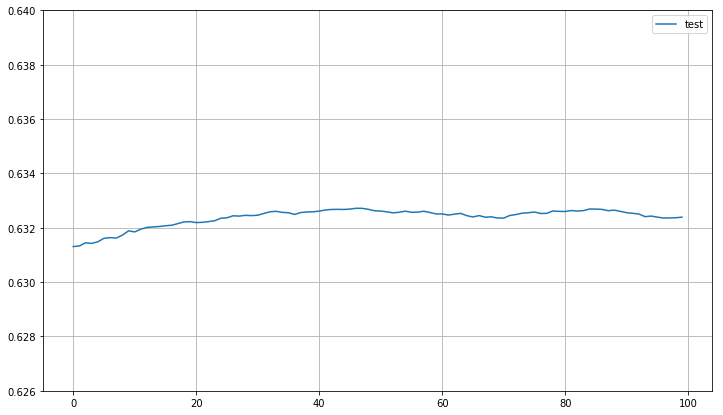

In [32]:
plt.figure(figsize=(12,7)) 
for i in models_4:
    plt.plot(range(len(i.information['valid_loss'])),i.information['valid_loss'],label='test')
    plt.legend()
    plt.yticks(np.arange(0.626, 0.64, 0.002))
    ax = plt.gca()
    ax.grid(True)

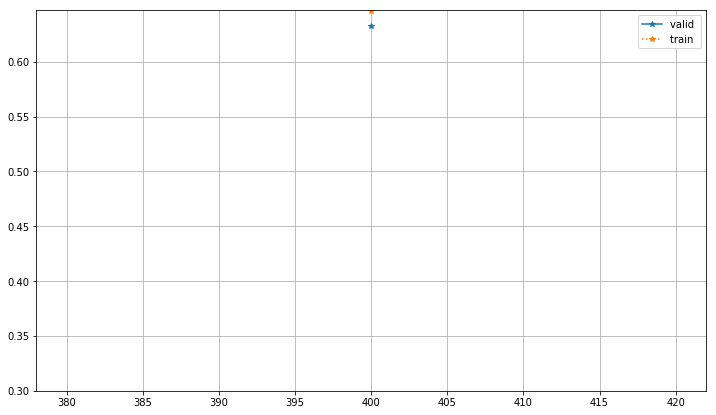

In [23]:
arguments = max_node_sizes
plt.figure(figsize=(12,7)) 
plt.plot(arguments,valid_scores,'-*',label='valid ')
plt.plot(arguments,train_scores,':*',label='train ')
plt.yticks(np.arange(0.3, 0.65, 0.05))
ax = plt.gca()
ax.grid(True)
plt.legend()

# 使用原始数据，归一化成0-1之间的数

In [48]:
train_X = np.load('wyf-train_X-80000-6-minmax.npy')
test_X = np.load('wyf-test_X-30000-6-minmax.npy')
train_Y = np.load('wyf-train_Y-80000.npy')

In [49]:
logger.setLevel(logging.INFO)
max_node_sizes = [10,20,40,80,160,320, 640]
n_splits = 1
cv = ShuffleSplit(n_splits=n_splits)
train_scores = []
valid_scores = []
models_5 = []
for train_indices, test_indices in cv.split(train_X):
    for max_node_size in max_node_sizes:
        lr = DecisionTreeRegressor(max_node_size=max_node_size, divide_way='half')
        lr.fit(train_X[train_indices], train_Y[train_indices])
        y_pred = lr.predict(train_X[test_indices])
        y_train_pred = lr.predict(train_X[train_indices])
        train_score = pearson_correlation(y_train_pred, train_Y[train_indices])
        valid_score = pearson_correlation(y_pred, train_Y[test_indices])
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        models_5.append(lr)
        logger.info("train score : {} valid score : {}".format(train_score, valid_score))

[    INFO] - [<ipython-input-49-3504ae6a2362>] - [ 19] - [  <module>] 
train score : 0.6521021465703163 valid score : 0.4388820549904094

[    INFO] - [<ipython-input-49-3504ae6a2362>] - [ 19] - [  <module>] 
train score : 0.5780029832774063 valid score : 0.4470616052325143

[    INFO] - [<ipython-input-49-3504ae6a2362>] - [ 19] - [  <module>] 
train score : 0.5195855752237014 valid score : 0.43809421840309554

[    INFO] - [<ipython-input-49-3504ae6a2362>] - [ 19] - [  <module>] 
train score : 0.4632028110597552 valid score : 0.41683496218133553

[    INFO] - [<ipython-input-49-3504ae6a2362>] - [ 19] - [  <module>] 
train score : 0.4042273041821446 valid score : 0.38879665437744904

[    INFO] - [<ipython-input-49-3504ae6a2362>] - [ 19] - [  <module>] 
train score : 0.37286747229153094 valid score : 0.3697602068438115

[    INFO] - [<ipython-input-49-3504ae6a2362>] - [ 19] - [  <module>] 
train score : 0.36161142558158654 valid score : 0.3648852019389614



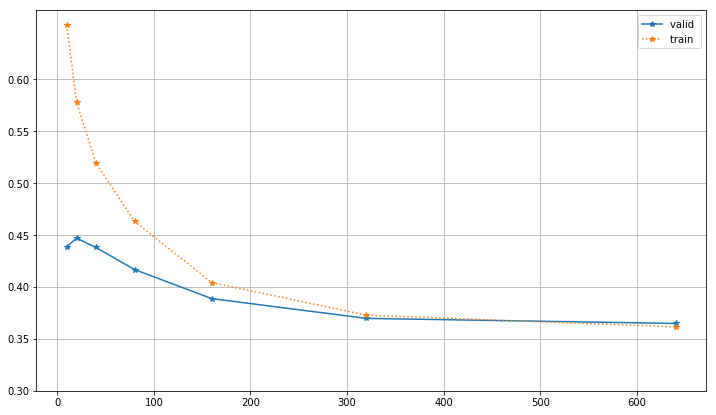

In [50]:
arguments = max_node_sizes
plt.figure(figsize=(12,7)) 
plt.plot(arguments,valid_scores,'-*',label='valid ')
plt.plot(arguments,train_scores,':*',label='train ')
plt.yticks(np.arange(0.3, 0.65, 0.05))
ax = plt.gca()
ax.grid(True)
plt.legend()

In [51]:
logger.setLevel(logging.INFO)
max_node_sizes = [10,20,40,80,160,320, 640]
n_splits = 1
cv = ShuffleSplit(n_splits=n_splits)
train_scores = []
valid_scores = []
models_6 = []
for train_indices, test_indices in cv.split(train_X):
    for max_node_size in max_node_sizes:
        lr = DecisionTreeRegressor(max_node_size=max_node_size, divide_way='default')
        lr.fit(train_X[train_indices], train_Y[train_indices])
        y_pred = lr.predict(train_X[test_indices])
        y_train_pred = lr.predict(train_X[train_indices])
        train_score = pearson_correlation(y_train_pred, train_Y[train_indices])
        valid_score = pearson_correlation(y_pred, train_Y[test_indices])
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        models_6.append(lr)
        logger.info("train score : {} valid score : {}".format(train_score, valid_score))

[    INFO] - [<ipython-input-51-afe694b36782>] - [ 19] - [  <module>] 
train score : 0.6737478138251137 valid score : 0.47587149443018684

[    INFO] - [<ipython-input-51-afe694b36782>] - [ 19] - [  <module>] 
train score : 0.6127129672979155 valid score : 0.4890806746873232

[    INFO] - [<ipython-input-51-afe694b36782>] - [ 19] - [  <module>] 
train score : 0.5707322785636223 valid score : 0.4971134646353375

[    INFO] - [<ipython-input-51-afe694b36782>] - [ 19] - [  <module>] 
train score : 0.5405879834755142 valid score : 0.49913335282788496

[    INFO] - [<ipython-input-51-afe694b36782>] - [ 19] - [  <module>] 
train score : 0.5248019636506317 valid score : 0.4992260243308344

[    INFO] - [<ipython-input-51-afe694b36782>] - [ 19] - [  <module>] 
train score : 0.5172588501572025 valid score : 0.4980594565088962

[    INFO] - [<ipython-input-51-afe694b36782>] - [ 19] - [  <module>] 
train score : 0.5129132450171232 valid score : 0.4976628034013752



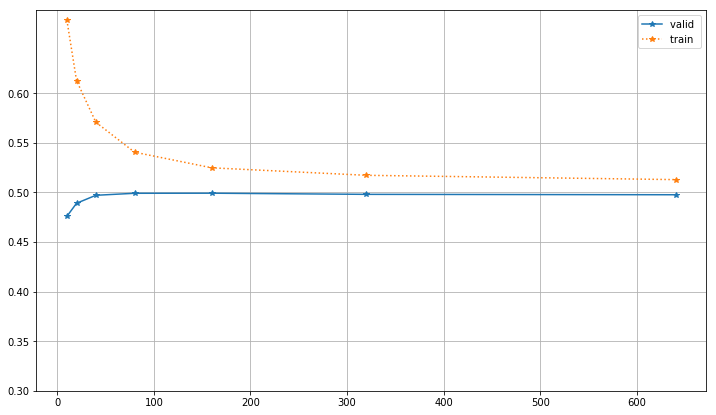

In [52]:
arguments = max_node_sizes
plt.figure(figsize=(12,7)) 
plt.plot(arguments,valid_scores,'-*',label='valid ')
plt.plot(arguments,train_scores,':*',label='train ')
plt.yticks(np.arange(0.3, 0.65, 0.05))
ax = plt.gca()
ax.grid(True)
plt.legend()